# Make HyperMapper solve Mnist

## Imports, yay

In [1]:
import pandas as pd
import math
import torch
import torch.nn as nn
import sys
from torch.autograd import Variable
import time

import numpy as np
import torch.utils.data as Data

#tds
import torchvision

#git
#from __future__ import print_function
#import argparse
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.optim.lr_scheduler import StepLR

import json

## Loads the MNIST data set

In [2]:
# I had issues with batch size because torch.utils only accepts batch size in type int 
# and not numpy.int64 (standard type for integers in numpy.array()).
# This I think is poor design but easy to work around
def get_mnist(b_size = 64):
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('data/', train=True, 
                                  download=True,
                                  transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size = b_size, 
                                    shuffle=True)

    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('data/', train=False, download=True,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size = 1000, shuffle=True)
    # print('loaded the mnist data')
    return train_loader, test_loader

## Translates HyperMapper json to pyTorch module

In [3]:
class json2pheno(nn.Module):
    def __init__(self, json, nin, nout):
        super(json2pheno, self).__init__()
        # build layers from genome encoding

        n_in = nin
        fw_map = {}

        """ What does json contain that we want here:
        n_nodes
        n_layers (All layers accept the output layer)
        skip (length of skip connection. may be 0)
        """ 
        n_nodes = json['n_nodes']
        n_layers = json['n_layers']
        skip = json['skip']
        if 'activation' in json:
            self.activation = json['activation']
        else:
            self.activation = 0
        
        # check so activation function is right
        if self.activation == 0:
             print('activation: tanh')
        elif self.activation == 1:
             print('activation: relu')
        else:
             print('error in act func')
        
        for i in range(n_layers):
            key = str(i)
            setattr(self, key, nn.Linear(n_in, n_nodes))
           
            # We are on the last hidden layer, so we will not have any skipps here
            if i == n_layers - 1:
                fw_map[key] = ['out']
                n_in = n_nodes
                break
            
            fw_map[key] = [str(i + 1)]
            
            # Add skips to the fw_map. If they are to long, sent them to output layer
            if skip:
                if i + skip + 1 < n_layers:
                    fw_map[key].append(str(i + skip + 1))
                else:
                    fw_map[key].append('out')

            
            # Again, this is same for all but first layer
            n_in = n_nodes

        setattr(self, 'out', nn.Linear(n_in, nout))
        
        # fw_scheme is a dict containing to which layers each layer is sending its output
        # This will fail if we have non-forward connections
        self.fw_scheme = fw_map
        print(self.fw_scheme)

    def forward(self, x):
        k = 0
        X = dict()
        X['0'] = [x.view(x.shape[0], -1)]
        while hasattr(self, str(k)):
            # pass trough all layers except the output layer
            key = str(k)

            # we might want to concat instead of sum, then we need to modify input_size in __init__
            temp_x = sum(X[key])
            # temp_out = torch.tanh(getattr(self, key)(temp_x))
            if self.activation == 0:
                temp_out = torch.tanh(getattr(self, key)(temp_x))
            elif self.activation == 1:
                temp_out = torch.relu(getattr(self, key)(temp_x))
            else:
                temp_out = getattr(self, key)(temp_x)
                
            # this seem to work when doing the list thing with x
            for target in self.fw_scheme[key]:
                if target in X:
                    X[target].append(temp_out)
                else:
                    X[target] = [temp_out]

            k += 1

        # if k = 0 we have no active layers and a perceptron model
        if k:
            temp_x = sum(X['out'])
        else:
            temp_x = x.view(x.shape[0],-1)

        # Softmax as we are dealing with multiclass clasification problems
        out = getattr(self, 'out')(temp_x)
        return F.log_softmax(out, dim = 1)


## Create a json scenario

In [4]:
def create_scenario(RS, BO=0, output_path = "output_samples.csv"):
    scenario = {}
    scenario["application_name"] = "mnist"
    scenario["optimization_objectives"] = ["Value"]
    scenario["input_parameters"] = {}
    scenario["output_data_file"] = output_path
    scenario["design_of_experiment"] = {}

    # doe: nbr of random samples
    # BO: nbr op BO iters. BO = 0 means only random sampling
    scenario["optimization_iterations"] = BO
    scenario["design_of_experiment"]["doe_type"] = "random sampling"
    scenario["design_of_experiment"]["number_of_samples"] = RS

    # number of units in the hidden layers
    n_nodes = {}
    n_nodes["parameter_type"] = "ordinal"
    n_nodes["values"] = [2**i for i in range(2, int(math.log(128, 2)) + 1)] # 16-128

    # number of layers, excluding output layer
    n_layers = {}
    n_layers["parameter_type"] = "ordinal"
    n_layers["values"] = [0, 1, 2]

    # Length of skip connections
    # I do this ordinal because I feel like integer parameters most oftenly sets to zero.
    skip = {}
    skip["parameter_type"] = "ordinal"
    skip["values"] = [0, 1]
    
    # Activation functions for hidden layers
    # I do this ordinal because when I did categorical I still got ints when unpacking
    activation = {}
    activation["parameter_type"] = "ordinal"
    activation["values"] = [0, 1]      # 0 = tanh, 1 = relu
    
    batch_size = {}
    batch_size["parameter_type"] = "ordinal"
    batch_size["values"] = [16, 32, 64, 128, 256]
    
    optimizer = {}
    optimizer["parameter_type"] = "ordinal"
    optimizer["values"] = [0, 1, 2]    # 0 = SGD, 1 = Adam, 2 = RMSprop. Learningrate not spec.

    scenario["input_parameters"]["n_nodes"] = n_nodes
    scenario["input_parameters"]["n_layers"] = n_layers
    scenario["input_parameters"]["skip"] = skip
    scenario["input_parameters"]["activation"] = activation   # optional param. deafult = tanh
    scenario["input_parameters"]["batch_size"] = batch_size   # optional param. default = 64
    scenario["input_parameters"]["optimizer"] = optimizer     # optional param. default = SGD


    %cd
    %cd "PycharmProjects/samuel_nas/my_hypermapper/example_scenarios/quick_start"
    with open("example_mnist_scenario.json", "w") as scenario_file:
        json.dump(scenario, scenario_file, indent=4)


## Trains a network and returns validation performance

In [5]:
def trainer(network, train_data, test_data, optimizer = 0):
    
    # Always uses cross entropy as loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimization algorithm given by the json
    if optimizer == 0:
        print('optimizer: sgd')
        # SGD requires lr to be set
        optimizer = optim.SGD(network.parameters(), lr=0.1)
    elif optimizer == 1:
        print('optimizer: adam')
        optimizer = optim.Adam(network.parameters())
    elif optimizer == 2:
        print('optimizer: rmsprop')
        optimizer = optim.RMSprop(network.parameters())
        
    # Train for a given number of epochs (1)
    t0 = time.perf_counter()
    for epoch in range(1):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            #running_loss += loss.item()
            #if i % 200 == 199:    # print every 200 mini-batches
             #   print('[%d, %5d] loss: %.3f' %
              #        (epoch + 1, i + 1, running_loss / 200))
               # running_loss = 0.0

    print('Finished Training it took ', (time.perf_counter() - t0)/60, ' minutes to train')

    # Validates performance on unseen data
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, labels = data
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print('Accuracy of the network on the 10000 test images: %d %%' % (
     #   100 * correct / total))

    return 1 - correct / total

## Objective function for hypermapper to optimize

In [6]:
def MNIST_function(X):
    """
    Compute the error rate on MNIST after training for a given time.
    :param X: dictionary containing the hyperparameters describing a network.
    :return: the validation performance of the network described by X
    """
    
    # Sets batch size if given in json. Otherwise defaults to 64
    # Gets issues with type when taken from array. Then it must be converted to int
    if 'batch_size' in X:
        batch_size = X['batch_size']
        if type(batch_size) != int:
            # print('not a pos int!! type: ', type(batch_size))
            batch_size = int(batch_size)
            #print('Now it should be int. type: ', type(batch_size))
            
        print(batch_size)
        train_loader, test_loader = get_mnist(batch_size)
    else:
        print('batch size not given, defaults to 64')
        train_loader, test_loader = get_mnist()
    
    # The input/output size of the network. 
    # for fully connected nets nin is nbr of pixels
    # for CNN nin would be number of chanels
    nin = 28**2
    nout = 10
    my_net = json2pheno(X, nin, nout)

    # Specifies optimizer if given in json scenario.
    if 'optimizer' in X:
        optimizer = X['optimizer']
        loss = trainer(my_net, train_loader, test_loader, optimizer)
    else:
        print('optimizer not given')
        loss = trainer(my_net, train_loader, test_loader)
    
    print('error: ', loss)
    print('\n')
    return loss

## Basically the main method. Optimizes the given function based on the given scenario. 

### Stores the results in op.cvs

In [7]:
# Took 14 minutes on my cpu to do 50 random samples and evaluate
# Took 9 minutes on my cpu to do 10 random samples and then 20 Bayesian Optimization steps
# Bayesian Optimization iteration takes about the same time as Random Search as search space is small

# creates a problem scenario and saves it as example_mnist_scenario.json
rs = 10
bo = 40
# op = "stupid.csv"
op = 'mnist_BO_10+40.csv'
create_scenario(rs, BO = bo, output_path = op)

%cd
%cd "PycharmProjects/samuel_nas/my_hypermapper/scripts"

import hypermapper
%cd ".."
parameters_file = "example_scenarios/quick_start/example_mnist_scenario.json"
# parameters_file = "example_branin_scenario.json"
t_start = time.perf_counter()
hypermapper.optimize(parameters_file, MNIST_function)
print('this entire procedure took ', (time.perf_counter() - t_start) / 60, 'minutes')


/home/samuel
/home/samuel/PycharmProjects/samuel_nas/my_hypermapper/example_scenarios/quick_start
/home/samuel
/home/samuel/PycharmProjects/samuel_nas/my_hypermapper/scripts
/home/samuel/PycharmProjects/samuel_nas/my_hypermapper
Design of experiment phase, number of doe samples = 10 .......
batch size is a pos int, it should work
16
activation: tanh
{'0': ['out']}
optimizer: rmsprop
Finished Training it took  0.17640323741664662  minutes to train
error:  0.27349999999999997


batch size is a pos int, it should work
32
activation: relu
{}
optimizer: adam
Finished Training it took  0.17528469665000254  minutes to train
error:  0.08879999999999999


batch size is a pos int, it should work
128
activation: tanh
{}
optimizer: adam
Finished Training it took  0.2588585240166746  minutes to train
error:  0.08360000000000001


batch size is a pos int, it should work
64
activation: tanh
{'0': ['1'], '1': ['out']}
optimizer: adam
Finished Training it took  0.22971529146664882  minutes to train
err

error:  0.08409999999999995


n_nodes,n_layers,skip,activation,batch_size,optimizer,Value,Timestamp
4,0,0,0,128,0,0.08409999999999995,451059

Starting optimization iteration 16
not a pos int!! type:  <class 'numpy.int64'>
Now it should be int. type:  <class 'int'>
16
activation: relu
{'0': ['out']}
optimizer: sgd
Finished Training it took  0.3389242710166703  minutes to train
error:  0.03049999999999997


n_nodes,n_layers,skip,activation,batch_size,optimizer,Value,Timestamp
128,1,0,1,16,0,0.03049999999999997,473477

Starting optimization iteration 17
not a pos int!! type:  <class 'numpy.int64'>
Now it should be int. type:  <class 'int'>
128
activation: tanh
{}
optimizer: adam
Finished Training it took  0.27693554519998237  minutes to train
error:  0.08179999999999998


n_nodes,n_layers,skip,activation,batch_size,optimizer,Value,Timestamp
4,0,0,0,128,1,0.08179999999999998,492140

Starting optimization iteration 18
not a pos int!! type:  <class 'numpy.int64'>
Now it should be int. type: 

not a pos int!! type:  <class 'numpy.int64'>
Now it should be int. type:  <class 'int'>
32
activation: tanh
{'0': ['1'], '1': ['out']}
optimizer: adam
Finished Training it took  0.35171062798332664  minutes to train
error:  0.03959999999999997


n_nodes,n_layers,skip,activation,batch_size,optimizer,Value,Timestamp
128,2,0,0,32,1,0.03959999999999997,872687

Starting optimization iteration 38
not a pos int!! type:  <class 'numpy.int64'>
Now it should be int. type:  <class 'int'>
64
activation: relu
{'0': ['out']}
optimizer: adam
Finished Training it took  0.22608801458330466  minutes to train
error:  0.0827


n_nodes,n_layers,skip,activation,batch_size,optimizer,Value,Timestamp
16,1,1,1,64,1,0.0827,888293

Starting optimization iteration 39
not a pos int!! type:  <class 'numpy.int64'>
Now it should be int. type:  <class 'int'>
64
activation: tanh
{'0': ['1'], '1': ['out']}
optimizer: adam
Finished Training it took  0.2561920993499977  minutes to train
error:  0.06310000000000004


n_node

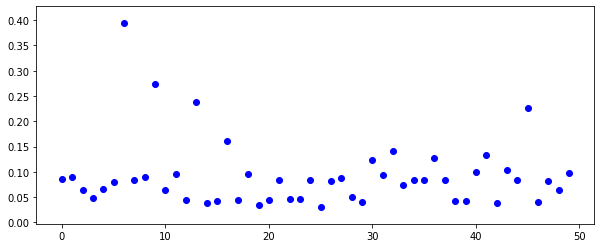

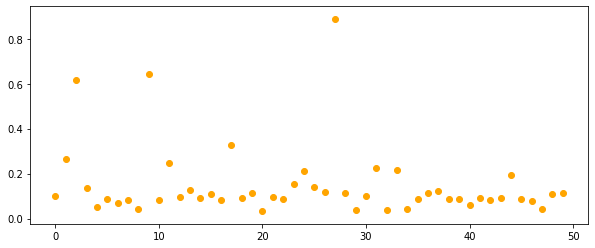

In [27]:
# I have to make a nice way to sort the data since the randomly generated points are in reversed order in
def make_scatter(data, color):
    scores = np.zeros((len(data),2))

    best = (-1, 1)
    for i in range(len(data)):
        value = data['Value'].iloc[i]
        if value < best[1]:
            best = (i, value)
        scores[i, :] = [i, value]  # RS is saved reversed


    %matplotlib inline
    import matplotlib.pyplot as plt

    # view data
    plt.figure(figsize=(10,4))

    plt.scatter(scores[:,0], scores[:,1], color = color)
    #plt.scatter(scores2[:,0], scores2[:,1], color = "blue")
    #plt.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
    #plt.suptitle('Performance of the best found archtectiure as a function of samples. We trained on MNIST for 4 epochs')
    #plt.xlabel('samples')
    #plt.ylabel('fraction wrongly classified in validation set')
    #plt.title('Regression Analysis')
    #plt.text(1.0, 0, 'Loss = %.4f' % loss,
                #fontdict={'size': 24, 'color':  'red'})
    plt.show()
    return best

d_BO = pd.read_csv('mnist_BO_10+40.csv')     
d_RS = pd.read_csv('mnist_RS_50.csv')    

bestBO = make_scatter(d_BO, 'blue')
bestRS = make_scatter(d_RS, 'orange')

best_arch_BO = d_BO.iloc[bestBO[0]]
best_arch_RS = d_RS.iloc[bestRS[0]]

print('best archtecture from BO: ', best_arch_BO)
print('best archtecture from RS: ', best_arch_RS)

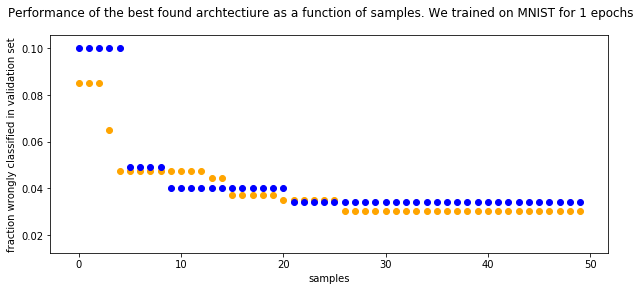

In [28]:
data = pd.read_csv ('mnist_BO_10+40.csv')   
data2 = pd.read_csv ('mnist_RS_50.csv')   

scores = np.zeros((len(data),2))
scores2 = np.zeros((len(data2),2))
scores[0, :] = [0, data['Value'].iloc[0]]
scores2[0, :] = [0, data2['Value'].iloc[0]]

for i in range(1, len(data)):
    scores[i, :] = [i, min(data['Value'].iloc[0:i])] # data is stored reversed
    scores2[i, :] = [i, min(data2['Value'].iloc[0:i])]
    
%matplotlib inline
import matplotlib.pyplot as plt

# view data
plt.figure(figsize=(10,4))

plt.scatter(scores[:,0], scores[:,1], color = "orange")
plt.scatter(scores2[:,0], scores2[:,1], color = "blue")
#plt.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
plt.suptitle('Performance of the best found archtectiure as a function of samples. We trained on MNIST for 1 epochs')
plt.xlabel('samples')
plt.ylabel('fraction wrongly classified in validation set')
#plt.title('Regression Analysis')
#plt.text(1.0, 0, 'Loss = %.4f' % loss,
            #fontdict={'size': 24, 'color':  'red'})
plt.show()

In [11]:
best_arch_BO

n_layers           1.0000
Value              0.0305
optimizer          0.0000
batch_size        16.0000
n_nodes          128.0000
Timestamp     473477.0000
skip               0.0000
activation         1.0000
Name: 25, dtype: float64

In [12]:
best_arch_RS

n_nodes          128.0000
n_layers           2.0000
skip               0.0000
activation         1.0000
batch_size        32.0000
optimizer          1.0000
Value              0.0343
Timestamp     516519.0000
Name: 20, dtype: float64

In [10]:
a = 3**22 + 1
if type(a) != int or a < 1:
    print('not an pos int')
else:
    print('pos int')

pos int


In [20]:
u = np.array([1,2,3])
a = False
if type(u[0]) == 'numpy.int64':
    a = True
np.flip(u)

array([3, 2, 1])

In [17]:
type(int(u[0]))

int